# Modelagem com Optuna
## Credit Scoring - Otimização Bayesiana de Hiperparâmetros

Este notebook utiliza **Optuna** para otimização de hiperparâmetros, uma alternativa mais eficiente ao GridSearch.

### Por que Optuna?

| Aspecto | GridSearch | Optuna |
|---------|-----------|--------|
| Método | Busca exaustiva | Otimização Bayesiana (TPE) |
| Eficiência | Testa TODAS combinações | Foca em regiões promissoras |
| Pruning | Não | Sim - para trials ruins |
| Visualizações | Não | Sim - gráficos integrados |

---
## 1. Configuração

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_contour
)
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

import xgboost as xgb
import lightgbm as lgb

RANDOM_STATE = 42
print("Bibliotecas carregadas!")

Bibliotecas carregadas!


In [2]:
# Carregar dados
import sys
sys.path.insert(0, '../src')

from credit_scoring.data.loader import load_german_credit

X, y = load_german_credit(save_raw=False)
print(f"Dataset: {X.shape[0]} amostras, {X.shape[1]} features")

Dataset: 1000 amostras, 20 features


---
## 2. Preparação dos Dados

In [3]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Identificar tipos
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessador
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

print(f"Treino: {len(X_train)}, Teste: {len(X_test)}")

Treino: 800, Teste: 200


---
## 3. Baseline: Logistic Regression

In [4]:
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced'))
])

baseline_pipeline.fit(X_train, y_train)

y_pred_base = baseline_pipeline.predict(X_test)
y_proba_base = baseline_pipeline.predict_proba(X_test)[:, 1]

print(f"Baseline (Logistic Regression):")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")

Baseline (Logistic Regression):
  ROC-AUC: 0.8058
  F1-Score: 0.6575


---
## 4. Optuna: XGBoost

### Definindo a função objetivo

In [5]:
def objective_xgb(trial):
    """Função objetivo para otimização do XGBoost."""
    
    # Definir espaço de busca
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    # Criar modelo
    model = xgb.XGBClassifier(
        **params,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        scale_pos_weight=2.33
    )
    
    # Pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    
    return scores.mean()

In [6]:
# Executar otimização
print("Otimizando XGBoost com Optuna...")
print("(~30 trials, pode levar alguns minutos)\n")

study_xgb = optuna.create_study(direction='maximize', study_name='xgboost_optimization')
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print(f"\nMelhor ROC-AUC (CV): {study_xgb.best_value:.4f}")

Otimizando XGBoost com Optuna...
(~30 trials, pode levar alguns minutos)



  0%|          | 0/30 [00:00<?, ?it/s]


Melhor ROC-AUC (CV): 0.7954


In [7]:
# Melhores parâmetros
print("Melhores Hiperparametros XGBoost:")
print("-" * 40)
for param, value in study_xgb.best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

Melhores Hiperparametros XGBoost:
----------------------------------------
  max_depth: 4
  learning_rate: 0.0439
  n_estimators: 136
  min_child_weight: 4
  subsample: 0.7872
  colsample_bytree: 0.7382
  gamma: 2.8137
  reg_alpha: 0.2376
  reg_lambda: 0.0012


In [8]:
# Treinar modelo final com melhores parâmetros
best_xgb = xgb.XGBClassifier(
    **study_xgb.best_params,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    scale_pos_weight=2.33
)

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_xgb)
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print(f"XGBoost (Optuna):")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")

XGBoost (Optuna):
  ROC-AUC: 0.7825
  F1-Score: 0.6043


---
## 5. Optuna: LightGBM

In [9]:
def objective_lgb(trial):
    """Função objetivo para otimização do LightGBM."""
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    model = lgb.LGBMClassifier(
        **params,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        verbose=-1
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    
    return scores.mean()

In [10]:
# Executar otimização
print("Otimizando LightGBM com Optuna...\n")

study_lgb = optuna.create_study(direction='maximize', study_name='lightgbm_optimization')
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)

print(f"\nMelhor ROC-AUC (CV): {study_lgb.best_value:.4f}")

Otimizando LightGBM com Optuna...



  0%|          | 0/30 [00:00<?, ?it/s]


Melhor ROC-AUC (CV): 0.7881


In [11]:
# Treinar modelo final
best_lgb = lgb.LGBMClassifier(
    **study_lgb.best_params,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    verbose=-1
)

lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_lgb)
])

lgb_pipeline.fit(X_train, y_train)

y_pred_lgb = lgb_pipeline.predict(X_test)
y_proba_lgb = lgb_pipeline.predict_proba(X_test)[:, 1]

print(f"LightGBM (Optuna):")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_lgb):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_lgb):.4f}")

LightGBM (Optuna):
  ROC-AUC: 0.7568
  F1-Score: 0.5547


---
## 6. Visualizações Optuna

In [12]:
# Histórico de otimização - XGBoost
fig = plot_optimization_history(study_xgb)
fig.update_layout(title='Historico de Otimizacao - XGBoost')
fig.show()

In [13]:
# Importância dos hiperparâmetros - XGBoost
fig = plot_param_importances(study_xgb)
fig.update_layout(title='Importancia dos Hiperparametros - XGBoost')
fig.show()

In [14]:
# Histórico de otimização - LightGBM
fig = plot_optimization_history(study_lgb)
fig.update_layout(title='Historico de Otimizacao - LightGBM')
fig.show()

---
## 7. Comparação Final

In [15]:
# Comparação
results = pd.DataFrame({
    'Model': ['Logistic Regression (Baseline)', 'XGBoost (Optuna)', 'LightGBM (Optuna)'],
    'ROC-AUC (Test)': [
        roc_auc_score(y_test, y_proba_base),
        roc_auc_score(y_test, y_proba_xgb),
        roc_auc_score(y_test, y_proba_lgb)
    ],
    'F1-Score (Test)': [
        f1_score(y_test, y_pred_base),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgb)
    ],
    'Best CV Score': [
        cross_val_score(baseline_pipeline, X, y, cv=5, scoring='roc_auc').mean(),
        study_xgb.best_value,
        study_lgb.best_value
    ]
})

print("COMPARACAO FINAL DE MODELOS")
print("=" * 70)
print(results.to_string(index=False))

COMPARACAO FINAL DE MODELOS
                         Model  ROC-AUC (Test)  F1-Score (Test)  Best CV Score
Logistic Regression (Baseline)        0.805833         0.657534       0.787929
              XGBoost (Optuna)        0.782500         0.604317       0.795387
             LightGBM (Optuna)        0.756786         0.554745       0.788095


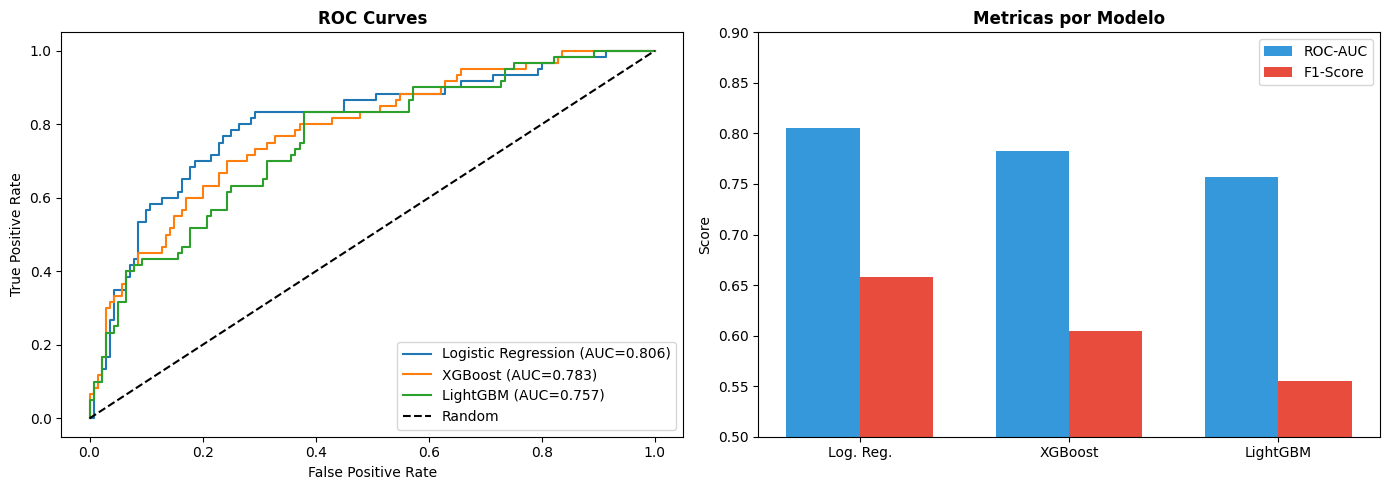

In [16]:
# Curvas ROC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
for name, y_prob in [('Logistic Regression', y_proba_base), 
                      ('XGBoost', y_proba_xgb), 
                      ('LightGBM', y_proba_lgb)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves', fontweight='bold')
ax.legend()

# Bar chart
ax = axes[1]
x = np.arange(len(results))
width = 0.35

bars1 = ax.bar(x - width/2, results['ROC-AUC (Test)'], width, label='ROC-AUC', color='#3498db')
bars2 = ax.bar(x + width/2, results['F1-Score (Test)'], width, label='F1-Score', color='#e74c3c')

ax.set_ylabel('Score')
ax.set_title('Metricas por Modelo', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Log. Reg.', 'XGBoost', 'LightGBM'])
ax.legend()
ax.set_ylim(0.5, 0.9)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison_optuna.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Salvar Melhor Modelo

In [17]:
import joblib

# Determinar melhor
best_idx = results['ROC-AUC (Test)'].idxmax()
best_model_name = results.loc[best_idx, 'Model']

if 'XGBoost' in best_model_name:
    best_model = xgb_pipeline
elif 'LightGBM' in best_model_name:
    best_model = lgb_pipeline
else:
    best_model = baseline_pipeline

# Salvar
joblib.dump(best_model, '../models/best_model_optuna.joblib')
results.to_csv('../reports/optuna_results.csv', index=False)

print(f"Melhor modelo: {best_model_name}")
print(f"Modelo salvo em: ../models/best_model_optuna.joblib")

Melhor modelo: Logistic Regression (Baseline)
Modelo salvo em: ../models/best_model_optuna.joblib


---
## 9. Resumo

In [18]:
print("=" * 70)
print("RESUMO DA OTIMIZACAO COM OPTUNA")
print("=" * 70)

print("\nCOMPARACAO:")
print(results.to_string(index=False))

print(f"\nMELHOR MODELO: {best_model_name}")
print(f"ROC-AUC: {results.loc[best_idx, 'ROC-AUC (Test)']:.4f}")

print("\n" + "=" * 70)

RESUMO DA OTIMIZACAO COM OPTUNA

COMPARACAO:
                         Model  ROC-AUC (Test)  F1-Score (Test)  Best CV Score
Logistic Regression (Baseline)        0.805833         0.657534       0.787929
              XGBoost (Optuna)        0.782500         0.604317       0.795387
             LightGBM (Optuna)        0.756786         0.554745       0.788095

MELHOR MODELO: Logistic Regression (Baseline)
ROC-AUC: 0.8058

